<h1><center>Bird Species Image Recognition</center></h1>
<h3><center>Brendon Bottle and Sean McManus</center></h3>

#### Importing libraries

In [13]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping
import random
from keras.applications import EfficientNetB0

# Load and Process Data

Data Source: https://www.kaggle.com/datasets/gpiosenka/100-bird-species

Initial data had 525 species of birds with 100 to 200 images per species in the training set. To make the training times more reasonable, we reduced the data down to 50 randomly selected species and only the first 100 training images for each species.

In [2]:
# Set file path for loading data
train_dir = "/Users/sean/Documents/University_of_denver/Deep Learning/Final Project/Data/50_birds/Train"
val_dir = "/Users/sean/Documents/University_of_denver/Deep Learning/Final Project/Data/50_birds/Validate"
test_dir ="/Users/sean/Documents/University_of_denver/Deep Learning/Final Project/Data/50_birds/Test"

In [3]:
##### Sean's MAC ######
train_data = []
# limit the number of images per sub directory in train
max_train_images = 100

for i in os.listdir(train_dir):
    if i == ".DS_Store":
        continue
    else:
        sub_dir = os.path.join(train_dir, i)
        image_count = 0
        for j in os.listdir(sub_dir):
            if image_count >= max_train_images:
                break
            image = cv2.imread(os.path.join(sub_dir, j))
            train_data.append([image, i])
            image_count += 1

# Create a Validation set
val_data = []
max_val_images = 10

for i in os.listdir(val_dir):
    if i == ".DS_Store":
        continue
    else:
        sub_dir = os.path.join(val_dir, i)
        image_count = 0
        for j in os.listdir(sub_dir):
            if image_count >= max_val_images:
                break
            image = cv2.imread(os.path.join(sub_dir, j))
            val_data.append([image, i])
            image_count += 1

# Create A test set
test_data = []
max_test_images = 10

for i in os.listdir(test_dir):
    if i == ".DS_Store":
        continue
    else:
        sub_dir = os.path.join(test_dir, i)
        image_count = 0
        for j in os.listdir(sub_dir):
            if image_count >= max_test_images:
                break
            image = cv2.imread(os.path.join(sub_dir, j))
            test_data.append([image, i])
            image_count += 1


print(len(train_data))
print(len(val_data))
print(len(test_data))

5000
250
250


#### Learning how to display the images

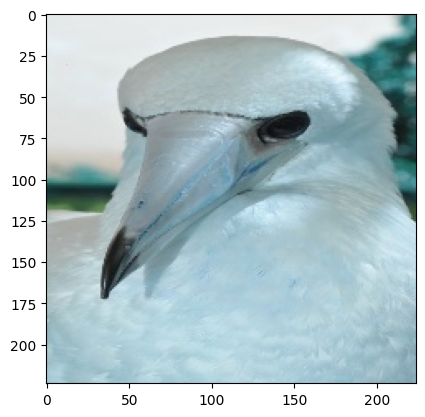

In [4]:
# displaying a single image directly from file name inline

img = cv2.imread("/Users/sean/Documents/University_of_denver/Deep Learning/Final Project/Data/50_birds/Train/ABBOTTS BOOBY/001.jpg", cv2.IMREAD_COLOR)
#Displaying image using plt.imshow() method
plt.imshow(img)
plt.show()

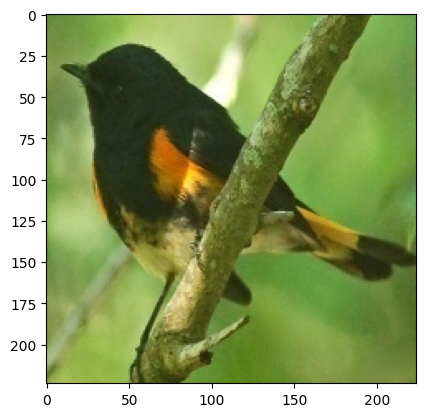

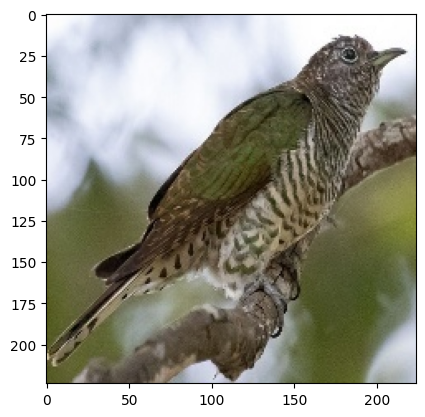

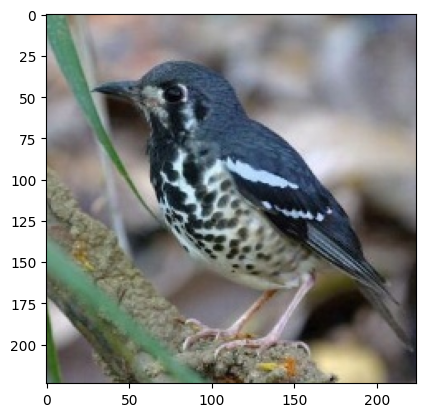

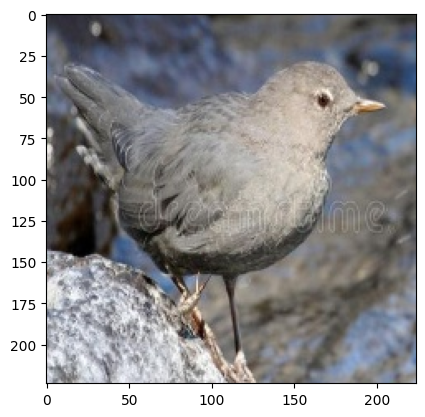

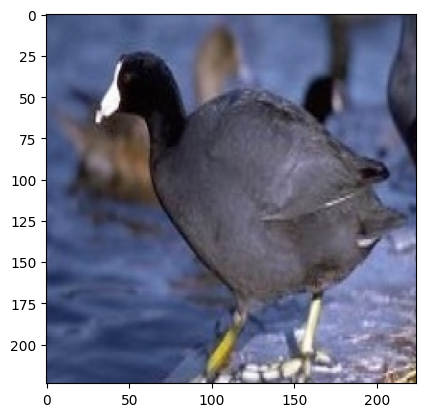

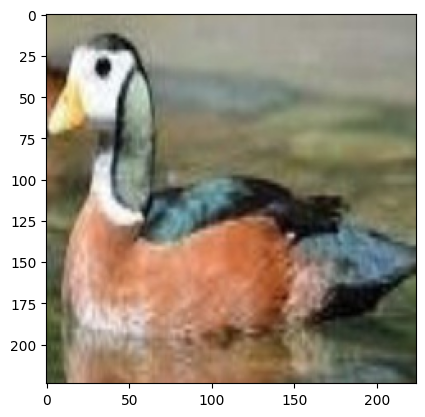

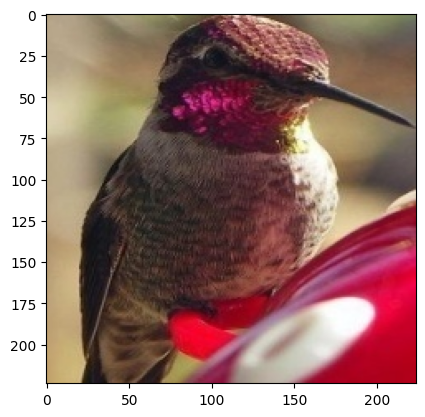

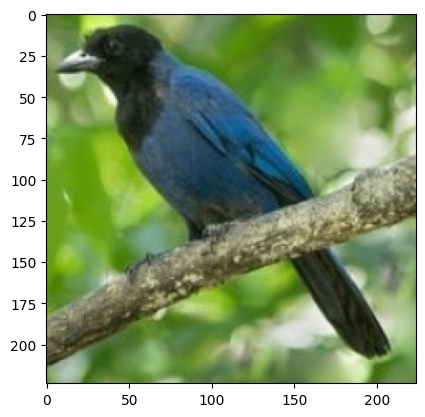

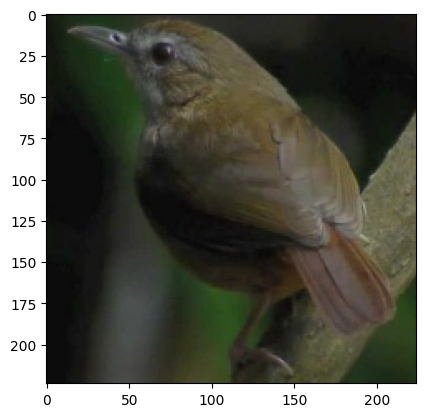

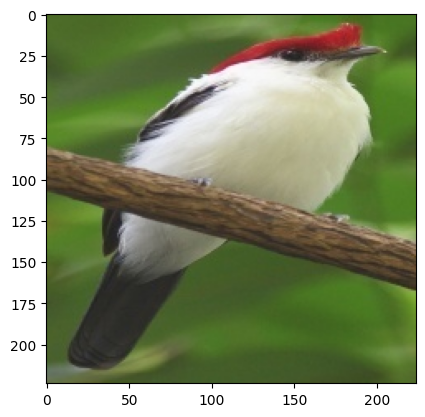

In [5]:
# Displaying multiple (or in this case just 1) image(s) from each species

max_sub_images = 1
max_total = 10

img_count = 0
for i in os.listdir(train_dir):
    if img_count >= max_total:
        break
    if i == ".DS_Store":
        continue
    else:
        sub_dir = os.path.join(train_dir, i)
        sub_image_count = 0
        
        for j in os.listdir(sub_dir):
            if sub_image_count >= max_sub_images:
                break
            image = cv2.imread(os.path.join(sub_dir, j))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
            img_count += 1
            sub_image_count += 1

In [6]:
# Validating that all images are the same shape

count_t = 0
count_v = 0

for t in train_data:
    if t[0].shape != (224, 224, 3):
        count_t += 1
    
for v in val_data:
    if v[0].shape != (224, 224, 3):
        count_v += 1

print(f'There are {count_t} images of different shape in the train data.\nThere are {count_v} images of different shape in the validation data.')
    

There are 0 images of different shape in the train data.
There are 0 images of different shape in the validation data.


In [7]:
# Shuffle data

np.random.seed(42)
np.random.shuffle(train_data)
np.random.shuffle(val_data)

In [8]:
# Preprocess training data and validation data
lb = LabelBinarizer()

X_train = []
y_train = []
for x, y in train_data:
    X_train.append(x)
    y_train.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)

y_train_vect = lb.fit_transform(y_train)

X_val = []
y_val = []
for x, y in val_data:
    X_val.append(x)
    y_val.append(y)

X_val = np.array(X_val)
y_val = np.array(y_val)

y_val_vect = lb.fit_transform(y_val)

### Evaluate on Baseline Model
The dataset authors noted that they had achieved good success using EfficientNetB0, so we decided to use that as our baseline model.

In [9]:
# Set early stopping parameters
callback = EarlyStopping(monitor= 'val_accuracy', patience= 5, start_from_epoch= 5)

In [10]:
# # Load Model 
# enet = EfficientNetB0(include_top= False, input_shape=(224, 224, 3))

# layers = enet.layers

# for layer in layers:
#     layer.trainable = False

# # Add a flatten and softmax layer
# model= Sequential([
#     enet,
#     Flatten(),
#     Dense(50, activation='softmax')
# ])

# # Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# history = model.fit(x = X_train, y= y_train_vect, batch_size=80, validation_data= (X_val, y_val_vect), verbose = 1, epochs = 8, callbacks = [callback])

#### Creating a base CNN model
##### The base model architecture will consist of one similar to what was demonstrated in class on mnist dataset:
+ A convolution layer
+ max pooling layer
+ 2nd convolution layer
+ 2nd max pooling layer
+ 3rd convolution layer
+ flattening layer
+ dense layer with a softmax output

In [17]:
# Assemble the base model layers
model1 = models.Sequential()
model1.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(64, 3, activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Conv2D(128, 3, activation='relu'))
model1.add(Flatten())
model1.add(layers.Dense(50, activation='softmax'))

# Compiling the model 
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
base_model_hist = model1.fit(x = X_train/255, y= y_train_vect, batch_size=30, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 8, callbacks = [callback])

Epoch 1/8
167/167 [==============================] - 63s 377ms/step - loss: 3.2978 - accuracy: 0.1850 - val_loss: 2.5159 - val_accuracy: 0.3360
Epoch 2/8
167/167 [==============================] - 62s 370ms/step - loss: 1.9278 - accuracy: 0.4976 - val_loss: 2.1728 - val_accuracy: 0.4400
Epoch 3/8
167/167 [==============================] - 61s 368ms/step - loss: 0.9881 - accuracy: 0.7368 - val_loss: 2.0324 - val_accuracy: 0.4640
Epoch 4/8
167/167 [==============================] - 62s 369ms/step - loss: 0.2343 - accuracy: 0.9388 - val_loss: 3.2752 - val_accuracy: 0.4360
Epoch 5/8
167/167 [==============================] - 62s 370ms/step - loss: 0.0502 - accuracy: 0.9880 - val_loss: 3.7009 - val_accuracy: 0.4640
Epoch 6/8
167/167 [==============================] - 62s 371ms/step - loss: 0.0387 - accuracy: 0.9926 - val_loss: 4.0833 - val_accuracy: 0.4120
Epoch 7/8
167/167 [==============================] - 62s 370ms/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 4.3371 - val_accuracy:

### Baseline model observations
+ We see that the model is very quickly fitting to our training data w/ an accuarcy of ~94% on the 4th epoch, however the validation accuracy is much much lower hovering around 40% after the 1st epoch and hardly improving

To handle the overfitting lets look at some things we might try addressing:
+ This is a relatively shallow network with only 3 convolution layers
+ There is no regularization or dropout occuring within this base model
+ We could increase the amount of data passed in

In [18]:
#### Exploring how dropout will affect the results
# Assemble the base model layers
model2 = models.Sequential()
model2.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(64, 3, activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(128, 3, activation='relu'))
model2.add(Flatten())
model2.add(layers.Dropout(.25))
model2.add(layers.Dense(50, activation='softmax'))

# Compiling the model 
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
drop_model_hist = model2.fit(x = X_train/255, y= y_train_vect, batch_size=30, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 8, callbacks = [callback])

Epoch 1/8
167/167 [==============================] - 64s 383ms/step - loss: 3.3468 - accuracy: 0.1872 - val_loss: 2.4350 - val_accuracy: 0.3320
Epoch 2/8
167/167 [==============================] - 63s 377ms/step - loss: 1.8466 - accuracy: 0.5164 - val_loss: 1.9951 - val_accuracy: 0.4480
Epoch 3/8
167/167 [==============================] - 63s 377ms/step - loss: 0.7973 - accuracy: 0.7876 - val_loss: 2.6278 - val_accuracy: 0.4560
Epoch 4/8
167/167 [==============================] - 64s 386ms/step - loss: 0.1775 - accuracy: 0.9508 - val_loss: 3.7333 - val_accuracy: 0.4400
Epoch 5/8
167/167 [==============================] - 63s 379ms/step - loss: 0.0506 - accuracy: 0.9870 - val_loss: 3.6361 - val_accuracy: 0.4680
Epoch 6/8
167/167 [==============================] - 63s 378ms/step - loss: 0.0154 - accuracy: 0.9970 - val_loss: 4.6312 - val_accuracy: 0.4640
Epoch 7/8
167/167 [==============================] - 64s 383ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 4.5870 - val_accuracy:

#### Observations
At this point adding a dropout layer had no effect on our overfitting issues, I suspect that the shallowness of our model is only recognizing very basic patters of birds using horizontal/vertical filters.
In order to learn more finetuned patterns such as plumage and feather structure we will need to increase the depth of our model

In [19]:
# Adding additional depth to our network, here we are at 6 convolution layers
model3 = models.Sequential()
model3.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(64, 3, activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, activation='relu'))
model3.add(Flatten())
model3.add(layers.Dense(50, activation='softmax'))

# Compiling the model 
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
deeper_model_hist = model3.fit(x = X_train/255, y= y_train_vect, batch_size=30, validation_data= (X_val/255, y_val_vect), verbose = 1, epochs = 8, callbacks = [callback])

Epoch 1/8
167/167 [==============================] - 70s 416ms/step - loss: 3.8350 - accuracy: 0.0288 - val_loss: 3.5185 - val_accuracy: 0.0720
Epoch 2/8
167/167 [==============================] - 69s 414ms/step - loss: 3.1568 - accuracy: 0.1524 - val_loss: 2.7843 - val_accuracy: 0.2200
Epoch 3/8
167/167 [==============================] - 68s 409ms/step - loss: 2.5077 - accuracy: 0.3106 - val_loss: 2.1775 - val_accuracy: 0.3920
Epoch 4/8
167/167 [==============================] - 68s 409ms/step - loss: 1.9869 - accuracy: 0.4390 - val_loss: 1.8535 - val_accuracy: 0.4800
Epoch 5/8
167/167 [==============================] - 69s 411ms/step - loss: 1.6325 - accuracy: 0.5402 - val_loss: 1.6856 - val_accuracy: 0.5280
Epoch 6/8
167/167 [==============================] - 69s 411ms/step - loss: 1.3485 - accuracy: 0.6072 - val_loss: 1.5629 - val_accuracy: 0.5840
Epoch 7/8
167/167 [==============================] - 70s 419ms/step - loss: 1.0571 - accuracy: 0.6822 - val_loss: 1.5426 - val_accuracy: